## Communication efficiency

In this assignment we are evaluating the communication efficiency of various distributed optimization algorithms for SVM classifier. We are using multi-class classifier which learns a vector model $w_j$ for each class $j \in [M]$ and uses the loss function 
$$L_i = \sum_{j \in [M]} \mathbb{I}\{j \neq y_i\}(\Delta + (w_j - w_{y_i})^T x_i)_+$$ 
for sample $x_i$ with class label $y_i \in [M]$. We added an extra bias dimension to $x_i$ that always holds the constant 1. The "MINST" dataset is partitioned into 10 individually processed disjoint subsets and the overall objective is defined in the form of 
$$min_w \frac{1}{10} \sum_{i\in[10]} f_i(w)$$

We provide short answers to the questions and summerize the results here, while the CA code is supplied below.
(parts a, c, and e - DGD) We ran following algorithms over master-worker network architecture with 10 workers and compared the convergence rate vs signaling denoted with $T$:
* decentralized gradient descent (DGD)
* our proposition for less communication and versions of DGD
* DGD with compressed signaling

The following plot shows the loss function in master node vs number of $w_j$ gradient exchanges (20 per iteration). 

<img src="img/CA5-DGD.png" width="400">

(part c - DGD) In order to reduce $T$, we proposed to run a few GD iterations (single agent SVM) in each worker and return the overall direction instead of the gradient. This method is more efficient if the workers have datasets with similar distributions, like our case. The convergence rate vs signaling may even improve as happened in this case, since the $w_j$ update direction stays close to the average update direction in internal loops, without communication. On the other hand, if the sample distribution is different among workers, for instance in a sensor network where workers have only access to local samples in a spatially varying evironment, the workers' models will diverge from the overall optimum in internal iterations and converge to local optimal values. 

(part d) We implemented two types of compression methods for signal exchanges. We demonstrate Q1 and Q2 with respect to 10 first samples in dataset

<img src="img/train10.png" width="300">
    
* (Q1) keep only $K$ values of a vector and set the rest to zero. Since we have images of 10 digits and most of the information is located in the center, we kept $1/4$ of the pixels corresponding to the center of images for each $w_j$.
<img src="img/train10Q1.png" width="300">

* (Q2) represent every element with fewer bits. To make the results comparable to the case with Q1 compression, we used 16float $w_j$ (default is 64float).

<img src="img/train10Q2.png" width="300">

(part e - DGD) We can see in the plot above that the (Q1) compression is much more restricting since $3/4$ of pixels carry 0 information; hence compared to (Q2) the convergence is slower. While in (Q2) the algorithm has the freedom to pick more informative pixels and the convergence is almost the same as DGD without compression.

(part b, c, e, DSM) We ran following algorithms over 2-star network architecture with 10 agents and compared the convergence rate vs signaling denoted with $T$:
* decentralized subgradient method (DSM)
* ADMM over network
* our proposition for less communication and versions of DSM and ADMM
* DSM and ADMM with compressed signaling


In order to derive the update equations of ADMM over Network for multiclass SVM loss we use the auxiliary variables $u_{i,j} = (w_j - w_{y_i})^T x_i$ and rewrite the problem with additional constrains as below

\begin{align}
min &\sum_{a \in [10]} \sum_{i \in \text{Dataset}} \sum_{j \in [M]} &&(\Delta\mathbb{I}\{j \neq y_i\} + u_{i,j})_+\\
\text{s.t.   } &{w_j}_a = {z_j}_{a,l} &&\forall l \in N_a \text{  and   } j \in [M]\\
&u_{i,j} = (w_j - w_{y_i})^T x_i &&\forall i, j
\end{align}


After writing the dual problem using the augmented lagrangian and simplifying the equations we get the following update rule for node $a$ which is infact very similar to DSM's rule

$${w_j}_a^{k+1} = \frac{1}{2} ({w_j}_a^k + \frac{1}{|N_a|}\sum_{l \in N_a} {w_j}_l^k)$$

The following plots show the average agent loss function (with colored regions between min and max agent loss) vs number of $w_j$ gradient exchanges (18 per iteration) for DSM and ADMM. We can see that DSM and ADMM are almost identical with small differences in final classification error and gradient norm after 10 iterations (see the code section)

<img src="img/CA5-DSM.png" width="400">
<img src="img/CA5-ADMM.png" width="400">

(part c - DSM) In order to reduce $T$, we proposed to run a few GD iterations (single agent SVM) in each worker and share the final $w_j$s with neighbors. This method is similar to the one mentioned for DGD and has the same pros and cons. Here we can see the improved convergence rate.

(part e - DSM) Same as the case for DGD


(part f) SVRG algorithm is illustrated below.

<img src="img/SVRG.png" width="400">

Considering a sturcture similar to our proposal in part c, the inner loop of SVRG can be implemented inside each worker/agent so that the agents only transmit the final $w_{j_T}^k$ and receive and consent over $\tilde\nabla f$. 

SAG algorithm is illustrated below.

<img src="img/SAG.png" width="400">

We can modify SAG the same way we did with DGD and DSM to have an internal loop where the agents run SAG internally for few iterations before sharing their information. 

In [1]:
#Our code is based on multiclass svm. We compute class scores for each sample $x_i$ using $Wx_i + b$ where $b$ is the bias and each row of $W$ is a classifier for one of the labels $j$. For simplicity we combine $b$ with $W$ and extend the vectors x_i with one additional dimension that always holds the constant 0.01. The loss function for $x_i$ is computed using $L_i = \sum_{j \neq y_i} \max(0, (w_j - w_{y_i})^T x + \delta)$ a (Wx_i + b). We minimize the average loss using decentralized gradient descent and distributed subgradient method.
import numpy as np
a_k = .003
a_k2 = .005
lambda_ = 1
delta = 1

sample_num = 6000
max_iter = 100

curves = {}

#read the dataset
mnist_dataset = np.load("./mnist.npz")

#reshape x_train and x_test into matrices [x1|x2|....|xM]
M, D1, D2 = mnist_dataset['x_train'].shape
x_train = mnist_dataset['x_train'].reshape(M, D1 * D2).T
#add the bias dimension
x_train = np.vstack([x_train, np.ones((1, M))])
x_train = (x_train / np.linalg.norm(x_train, axis = 0))[:,:sample_num]
y_train = mnist_dataset['y_train'].reshape(M, 1).astype(int)[:sample_num]

M_test, D1, D2 = mnist_dataset['x_test'].shape
x_test = mnist_dataset['x_test'].reshape(M_test, D1 * D2).T
#add the bias dimension
x_test = np.vstack([x_test, np.ones((1, M_test))])
x_test = (x_test / np.linalg.norm(x_test, axis = 0))[:,:sample_num]
y_test = mnist_dataset['y_test'].reshape(M_test, 1).astype(int)[:sample_num]

#Split dataset to 10 partitions
workers_x = np.split(x_train, (np.arange(1, 10) * .1 * x_train.shape[1]).astype(int), axis = 1)
workers_y = np.split(np.array(y_train), (np.arange(1, 10) * .1 * x_train.shape[1]).astype(int), axis = 0)

In [2]:
#wrong classification percentage
def nmae(y,yhat):
    y = np.array(y).reshape(y.shape[0],1)
    yhat = np.array(yhat).reshape(yhat.shape[0],1)
    result = np.sum(y != yhat).astype(float)/(y.shape[0])
    return result

In [3]:
#multiclass SVM classification loss and its gradient
def SVM_classify(x, w):
    return np.argmax(np.matmul(x.T, w), axis = 1).reshape(x.shape[1], 1)

def SVM_cost(x, y, w):
    svm_cost = (np.matmul(x.T, w) - np.repeat(np.multiply(x.T, w[:,y.reshape(y.shape[0])].T).sum(axis = 1).reshape(y.shape[0], 1), 10, axis = 1) + delta).clip(min = 0)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] = 0
    return svm_cost

def regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum() + lambda_/2 * np.linalg.norm(w)**2

def SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad_coef = svm_cost
    svm_cost_grad_coef[(range(y.shape[0]), y.reshape(y.shape[0]))] -= svm_cost.sum(axis=1)
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_grad[:, i] = np.multiply(svm_cost_grad_coef[:, i].reshape(svm_cost_grad_coef.shape[0], 1), x.T).sum(axis = 0)
    return svm_cost_grad


In [4]:
#binary SVM classification one-vs-rest loss and its gradient
def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    class_votes = np.zeros(scores.shape())
    class_votes[scores > 0] += 1
    for i in range(10):
        class_votes[scores[:,i] <= 0,:] += 1
    class_votes[scores <= 0] -= 1
    return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)
            
def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)

def bin_regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum(axis = 1) + lambda_/2 * np.linalg.norm(w, axis = 1)**2

def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi.T).sum(axis = 0) + lambda_ * w[:, i]
    return svm_cost_grad

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot greyscale plots of computed models of each digit
def plot_w_ks(w_k):
    fig, axarr = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        axarr[i / 5, i % 5].imshow(w_k[:28*28,i].reshape(28, 28), cmap='gray', interpolation='none')
        axarr[i / 5, i % 5].set_title("Digit: {}".format(i))
        axarr[i / 5, i % 5].set_xticks([])
        axarr[i / 5, i % 5].set_yticks([])

    plt.show()

In [37]:
import matplotlib.cm as cm

#plot loss vs signaling at master node
def plot_master_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k]))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        T, loss = zip(*errs)
        plt.plot(T, loss, color = next(colors))
        legends.append(legend)
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    plt.title('Convergence vs signaling (%s)' % k)
    if len(legends) > 1:
        plt.legend(legends)
    plt.show()


In [38]:
#plot average agent loss vs signaling and the region between min and max loss
def plot_agents_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k].keys()))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        color = next(colors)
        T, losses = zip(*errs)
        legends.append(legend)
        losses = zip(*losses)
        mean = np.array(losses).mean(axis = 0)
        lmin = np.array(losses).min(axis = 0)
        lmax = np.array(losses).max(axis = 0)
        var = np.array(losses).var(axis = 0)
        plt.plot(T, mean, color = color)
        plt.fill_between(T, lmin, lmax,facecolor = color, alpha=0.2, edgecolor='none')
        #plt.fill_between(T, mean - var, mean + var,facecolor = color, alpha=0.2, edgecolor='none')
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    if len(legends) > 1:
        plt.legend(legends)
    plt.title('Convergence vs signaling (%s)' % k)
    plt.show()


In [8]:
#single agent GD SVM
def gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 

#w_k = np.random.rand((x_train.shape[0] * 10)).reshape(x_train.shape[0],10)
#w_k, errs = gradient_descent(x_train, y_train, w_k, lambda_, a_k, max_iter)

#y_predict = SVM_classify(x_train, w_k)
#print("Training classification error: %.3f" % nmae(y_train, y_predict))
#y_predict = SVM_classify(x_test, w_k)
#print("Test classification error: %.3f" % nmae(y_test, y_predict))

#plot_w_ks(w_k)

#plt.plot(range(max_iter), errs)
#plt.xlabel("Signaling (T)")
#plt.ylabel("Loss")
#plt.title('Convergence vs signaling (%s)' % 'single')
#plt.show()

In [9]:
#single agent binary GD SVM
def bin_gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = np.linalg.norm(bin_regulated_total_cost(x, y, w_k, lambda_))
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = bin_SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = np.linalg.norm(regulated_total_cost(x, y, w_k, lambda_))
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 

#w_k = np.random.rand((x_train.shape[0] * 10)).reshape(x_train.shape[0],10)
#w_k, errs = gradient_descent(x_train, y_train, w_k, lambda_, a_k, max_iter)

#y_predict = SVM_classify(x_train, w_k)
#print("Training classification error: %.3f" % nmae(y_train, y_predict))
#y_predict = SVM_classify(x_test, w_k)
#print("Test classification error: %.3f" % nmae(y_test, y_predict))

#plot_w_ks(w_k)

#plt.plot(range(max_iter), errs)
#plt.xlabel("Signaling (T)")
#plt.ylabel("Loss")
#plt.title('Convergence vs signaling (%s)' % 'single')
#plt.show()

a) Run decentralized GD (from Lecture 5) with 10 workers. Characterize the convergence
against the total number of signaling exchanges among all nodes, denoted by T.

In [10]:
#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with probability p
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    grad_w = SVM_cost_grad(x, y, w_k, lambda_)
    return 1, np.array(grad_w)


def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)


In [11]:
from multiprocessing.pool import ThreadPool

#Master updates the gradient w.r.t w_k for each class
def decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_):
    w_k = w_k - a_k * grad_w.mean(axis = 0).reshape(w_k.shape)
    return 10, w_k


#DGD
def decentralized_gradient_descent(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    T = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_])
        #results = []
        #for i in range(10):
        #    results.append(decentralized_gradient_descent_worker(*zipped[i]))
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        signals, grad_w = zip(*results)
        grad_w = np.array(grad_w)
        T += np.array(signals).sum()
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
        #master updates w_ks
        signals, w_k = master(w_k, a_k, grad_w, x, y, lambda_)
        T += signals
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append((T, L1))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs


In [12]:
from datetime import datetime

#run DGD
print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))


curves['decentralized gradient descent'] = {'no compression':(w_k, errs)}

2019-04-13 00:42:58.349921
Final loss = 3836.442 and gradient norm = 201.888
2019-04-13 00:43:43.695024
Training classification error: 0.103
Test classification error: 0.139


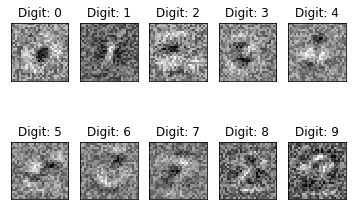

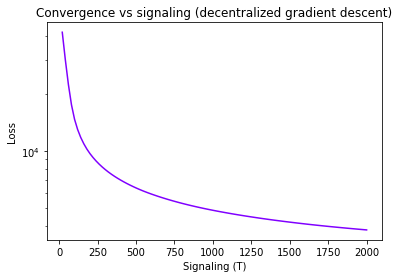

In [13]:
#plot greyscale models and master loss for DGD
plot_w_ks(curves['decentralized gradient descent']['no compression'][0])

plot_master_loss('decentralized gradient descent')

b) Consider a two-star topology with communication graph (1,2,3,4)-5-6-(7,8,9,10) and
run decentralized subgradient method (from Lecture 5) and ADMM over network (from
Lecture 6). Characterize the convergence against T . Tune hyperparameters to improve
the convergence rate.

In [14]:
#communication graph
A = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]])


In [15]:
#agent process for DSM
def decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = w_k[Ai == 1].mean(axis = 0)
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_)
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() - 1, bar_w_k, grad_w

def decentralized_subgradient_method_agent_(args):
    return decentralized_subgradient_method_agent(*args)


In [16]:
#The difference between DSM and ADMM formulation is that after simplification of ADMM update equations, we get the update rule w_i^{k+1} = 1/2 w_i^k + \sum_{j \in N_i}{w_j^k} in node i instead of avergaing over all nodes in connection
A_ADMM = A - np.eye(10) + np.diag((A - np.eye(10)).sum(axis = 0))

#agent process for ADMM
def admm_over_network_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = np.multiply(w_k, np.repeat(np.repeat(Ai.reshape(10, 1, 1), x.shape[0], axis = 1), 10, axis=2)).sum(axis = 0) / Ai.sum()
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_)
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() / 2, bar_w_k, grad_w

def admm_over_network_agent_(args):
    return admm_over_network_agent(*args)


In [17]:
from multiprocessing.pool import ThreadPool

#decentralized optimization over network
def decentralized_method(x, y, workers_x, workers_y, lambda_, a_k, max_iter, A, agent_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(10, x.shape[0], 10)
    T = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_)
    for k in range(max_iter):
        L = L1
        #transmit w_ks and 
        workers_w_k = np.array(10 * [w_k]).reshape(10, 10, x.shape[0], 10)
        if compress is not None:
            compressed_w_k = np.zeros((10, x.shape[0], 10))
            for i in range(10):
                compressed_w_k[i] = compress(w_k[i])
            workers_w_k = np.array(10 * [compressed_w_k]).reshape(10, 10, x.shape[0], 10)
            for i in range(10):
                workers_w_k[i, i] = w_k[i]
        #each agent gets a copy of w_ks of neighbors, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(A, workers_x, workers_y, workers_w_k, 10 * [lambda_], 10 * [a_k])
        #results = []
        #for i in range(10):
        #    results.append(decentralized_method_agent(*zipped[i]))
        pool = ThreadPool(10)
        results = pool.map(agent_, zipped)
        pool.close()
        pool.join()
        signals, w_k, grad_w = zip(*results)
        grad_w = np.array(grad_w)
        w_k = np.array(w_k)
        T += np.array(signals).sum()
        L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_)
        L1s = []
        for i in range(10):
            L1s.append(regulated_total_cost(x, y, w_k[i], lambda_))
        errs.append((T, L1s))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w.mean(axis = 0))))
    return w_k.mean(axis = 0).reshape(x.shape[0],10), errs

In [18]:
from datetime import datetime
#run DSM
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method'] = {'no compression':(w_k, errs)}

#run ADMM
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training accuracy: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test accuracy: %.3f" % nmae(y_test, y_predict))


curves['ADMM over network'] = {'no compression':(w_k, errs)}

2019-04-13 00:43:46.660392
Final loss = 3298.662 and gradient norm = 18.356
2019-04-13 00:47:02.149890
Training classification error: 0.090
Test classification error: 0.124
2019-04-13 00:47:02.201602
Final loss = 3401.292 and gradient norm = 21.696
2019-04-13 00:50:32.538185
Training accuracy: 0.093
Test accuracy: 0.128


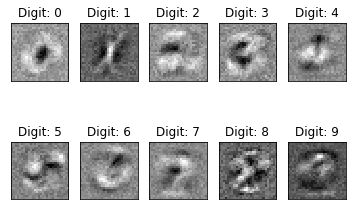

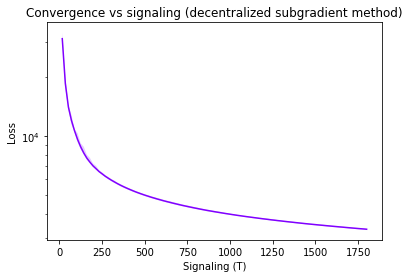

In [19]:
#plot greyscale models and average agent loss for DSM
plot_w_ks(curves['decentralized subgradient method']['no compression'][0])

plot_agents_loss('decentralized subgradient method')


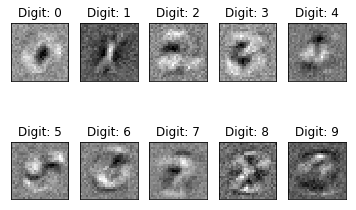

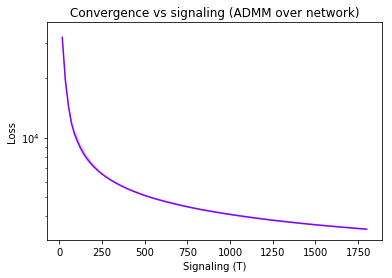

In [20]:
#plot greyscale models and average agent loss for ADMM
plot_w_ks(curves['ADMM over network']['no compression'][0])

plot_agents_loss('ADMM over network')

c) Propose an approach to reduce T with a marginal impact on the convergence. Do not limit your imaginations and feel free to propose any change or any solution. While being nonsense in some applications, your solution may actually make very sense in some other applications. Discuss pros and cons of your solution and possibly provide numerical evidence that it reduces T.

In [21]:
#To reduce T we propose to modify the algorithms in this way:
# we run single agent SVM optimization for a few iterations in each worker/agent and compute a few steps of GD individually at each agent
max_iter1 = 3
#In decentralized gradient descent workers share their overall direction.

def mod_decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    w_k1, errs = gradient_descent(x, y, w_k, lambda_, a_k, max_iter = max_iter1)
    return 1, np.array(w_k - w_k1)/a_k

def mod_decentralized_gradient_descent_worker_(args):
    return mod_decentralized_gradient_descent_worker(*args)


In [22]:
#run DGD with reduced communication
print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, mod_decentralized_gradient_descent_worker_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized gradient descent']['less communication'] = (w_k, errs)

2019-04-13 00:50:35.621486
Final loss = 2751.958 and gradient norm = 394.483
2019-04-13 00:52:56.806841
Training classification error: 0.085
Test classification error: 0.122


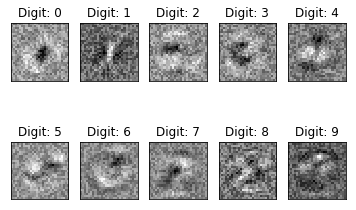

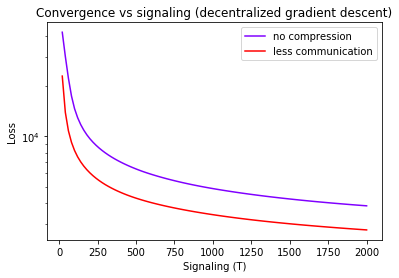

In [23]:
#plot greyscale models and master loss for DGD with less communication
plot_w_ks(curves['decentralized gradient descent']['less communication'][0])

plot_master_loss('decentralized gradient descent')

In [24]:
##In decentralized subgradient method agents share their final w_k model resulting from thier internal loop

def mod_decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = w_k[Ai == 1].mean(axis = 0)
    w_k1, errs = gradient_descent(x, y, bar_w_k, lambda_, a_k, max_iter = max_iter1)
    return Ai.sum() - 1, w_k1, np.array(w_k - w_k1) / a_k

def mod_decentralized_subgradient_method_agent_(args):
    return mod_decentralized_subgradient_method_agent(*args)

def mod_admm_over_network_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = np.multiply(w_k, np.repeat(np.repeat(Ai.reshape(10, 1, 1), x.shape[0], axis = 1), 10, axis=2)).sum(axis = 0) / Ai.sum()
    w_k1, errs = gradient_descent(x, y, bar_w_k, lambda_, a_k, max_iter = max_iter1)
    return Ai.sum() / 2,w_k1, np.array(w_k - w_k1) / a_k

def mod_admm_over_network_agent_(args):
    return mod_admm_over_network_agent(*args)


In [25]:
#run DSM with less communication
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, mod_decentralized_subgradient_method_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method']['less communication'] = (w_k, errs)

#run ADMM with less communication
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, mod_admm_over_network_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))


curves['ADMM over network']['less communication'] = (w_k, errs)

2019-04-13 00:52:58.636452
Final loss = 2474.605 and gradient norm = 850.399
2019-04-13 00:58:22.316334
Training classification error: 0.077
Test classification error: 0.115
2019-04-13 00:58:22.380313
Final loss = 2579.681 and gradient norm = 994.538
2019-04-13 01:03:39.096549
Training classification error: 0.080
Test classification error: 0.116


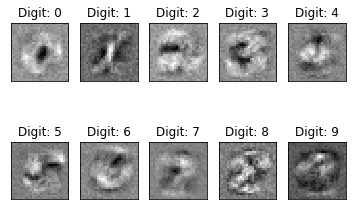

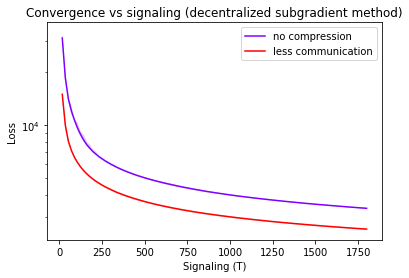

In [26]:
#plot greyscale models and average agent loss for DSM with less communication
plot_w_ks(curves['decentralized subgradient method']['less communication'][0])

plot_agents_loss('decentralized subgradient method')

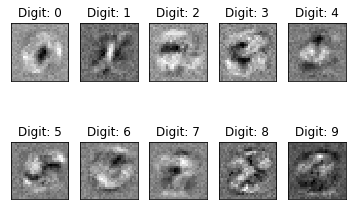

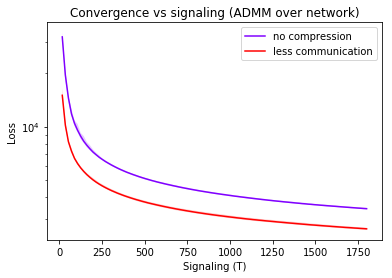

In [27]:
#plot greyscale models and average agent loss for ADMM with less communication
plot_w_ks(curves['ADMM over network']['less communication'][0])

plot_agents_loss('ADMM over network')

d) An alternative approach to improve communication-efficiency is to compress the information message to be exchanged (usually gradients – either in primal or dual forms). Consider two compression/quantization methods for a vector: (Q1) keep only K values of a vector and set the rest to zero and (Q2) represent every element with fewer bits (e.g., 4 bits instead of 32 bits).

In [28]:
#Q1 and Q2 compression functions
imcenterinds = (np.arange(0, 14*14).reshape(14, 14) + 7 + 28 * 7 + np.repeat(np.arange(0, 14).reshape(14, 1) * 14, 14, axis = 1)).reshape(14*14)

def Q1_of_w(w):
    w1 = np.zeros(w.shape)
    for i in range(10):
        w1[(imcenterinds,len(imcenterinds) * [i])] = w[(imcenterinds,len(imcenterinds) * [i])]
        w1[784, i] = w[784, i]
    return w1

def Q2_of_w(w):
    return w.astype(np.float16).astype(np.float64)


e) Repeat parts a-b using Q1 and Q2. Can you integrate Q1/Q2 to your solution in part d? Discuss.

In [29]:
#run DGD with Q1 and Q2 compression
print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_, compress = Q1_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized gradient descent']['Q1'] = (w_k, errs)

print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_, compress = Q2_of_w)
print(datetime.now())


y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized gradient descent']['Q2'] = (w_k, errs)

2019-04-13 01:03:42.877027
Final loss = 5209.966 and gradient norm = 202.625
2019-04-13 01:04:39.163400
Training classification error: 0.135
Test classification error: 0.178
2019-04-13 01:04:39.210727
Final loss = 3861.917 and gradient norm = 201.652
2019-04-13 01:05:36.814569
Training classification error: 0.104
Test classification error: 0.143


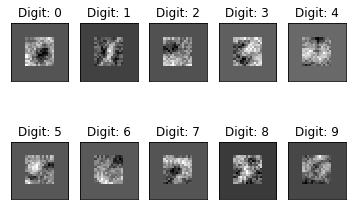

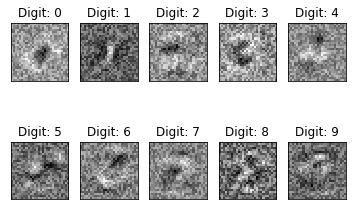

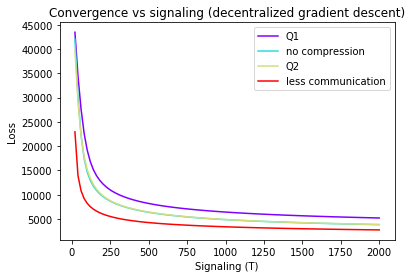

In [39]:
#plot greyscale models and master loss for compressed DGD
plot_w_ks(curves['decentralized gradient descent']['Q1'][0])

plot_w_ks(curves['decentralized gradient descent']['Q2'][0])

plot_master_loss('decentralized gradient descent')

In [31]:
#run DSM with Q1 and Q2 compression
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_, compress = Q1_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method']['Q1'] = (w_k, errs)

print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_, compress = Q2_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method']['Q2'] = (w_k, errs)

#run ADMM with Q1 and Q2 compression
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_, compress = Q1_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['ADMM over network']['Q1'] = (w_k, errs)

print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_, compress = Q2_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['ADMM over network']['Q2'] = (w_k, errs)

2019-04-13 01:05:39.680222
Final loss = 4598.128 and gradient norm = 35.601
2019-04-13 01:10:03.400591
Training classification error: 0.123
Test classification error: 0.164
2019-04-13 01:10:03.479594
Final loss = 3304.848 and gradient norm = 18.084
2019-04-13 01:15:38.271804
Training classification error: 0.091
Test classification error: 0.126
2019-04-13 01:15:38.353251
Final loss = 4669.847 and gradient norm = 39.063
2019-04-13 01:19:40.723519
Training classification error: 0.124
Test classification error: 0.167
2019-04-13 01:19:40.797897
Final loss = 3390.961 and gradient norm = 21.337
2019-04-13 01:24:02.560523
Training classification error: 0.090
Test classification error: 0.128


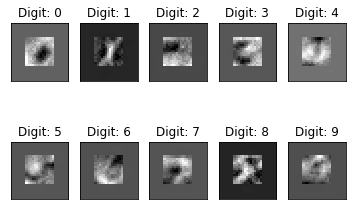

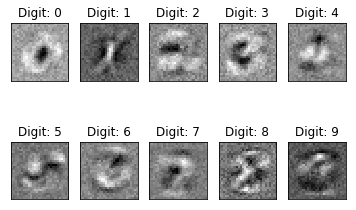

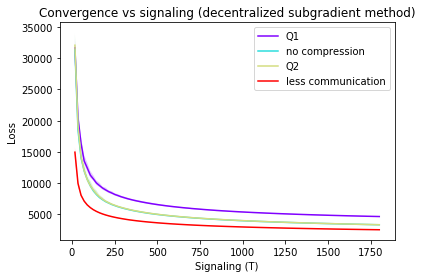

In [40]:
#plot greyscale models and average agent loss for compressed DSM
plot_w_ks(curves['decentralized subgradient method']['Q1'][0])

plot_w_ks(curves['decentralized subgradient method']['Q2'][0])

plot_agents_loss('decentralized subgradient method')

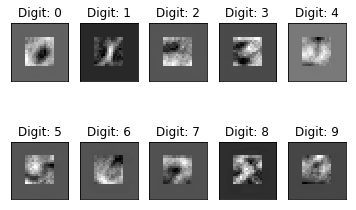

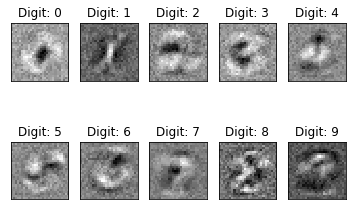

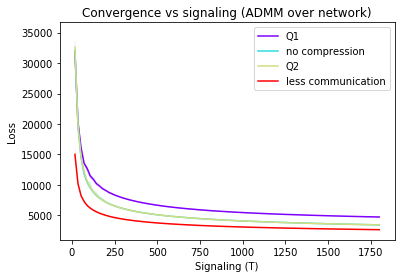

In [41]:
#plot greyscale models and average agent loss for compressed ADMM
plot_w_ks(curves['ADMM over network']['Q1'][0])

plot_w_ks(curves['ADMM over network']['Q2'][0])

plot_agents_loss('ADMM over network')

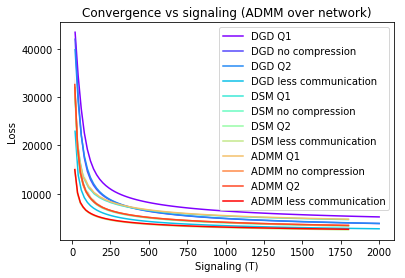

In [35]:
colors = iter(cm.rainbow(np.linspace(0, 1, 4 * 3)))
legends = []
k = 'decentralized gradient descent'
for legend in curves[k].keys():
    w_k, errs = curves[k][legend]
    T, loss = zip(*errs)
    plt.plot(T, loss, color = next(colors))
    legends.append('DGD %s' %(legend))

for k, l in [('decentralized subgradient method', 'DSM'), ('ADMM over network', 'ADMM')]:
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        color = next(colors)
        T, losses = zip(*errs)
        legends.append('%s %s' %(l,legend))
        losses = zip(*losses)
        mean = np.array(losses).mean(axis = 0)
        lmin = np.array(losses).min(axis = 0)
        lmax = np.array(losses).max(axis = 0)
        var = np.array(losses).var(axis = 0)
        plt.plot(T, mean, color = color)
        plt.fill_between(T, lmin, lmax,facecolor = color, alpha=0.2, edgecolor='none')
        #plt.fill_between(T, mean - var, mean + var,facecolor = color, alpha=0.2, edgecolor='none')

plt.xlabel("Signaling (T)")
plt.ylabel("Loss")
#plt.yscale("log")
plt.title('Convergence vs signaling (%s)' % k)
if len(legends) > 1:
    plt.legend(legends)
plt.show()

